# Notebook for performance evaluation of techniques

**We have four methods:**

- Raw Attention (seems to be only mean of weights from input embeddings on first layer).
- Attention flow (best in final layer).
- Attention Rollout (best in final layer).
- Gradient Attention Rollout (best in final layer (most likely)).

**We have two possible methods for metric evaluation:**

- Blank-out -> generate black spots and look at drop in accuracy.
- Gradient input -> **(?)**.

**Pipeline for evaluating models:**

- Select $N$ images for study.
- For each image (also can be done in multiple layers, but time constraint): 
    - Compute its raw attention, attention flow, rollout, and gradient rollout.
    - Compute the blank-out and gradient input.
    - Each will yield a vector of size $n_{embedding}$.
    - Compute Spearman rank correlation between them and store it

We should end up with a table of size $n_{images} \times n_{methods}$. It suffices to compute mean and standard deviation for each method.

In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
from vit_flow_inverse import VITAttentionFlowInverse

import copy
import requests
import torch.nn.functional as F

from tqdm import tqdm

/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
DEVICE = 'cpu'

In [3]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)
print()

Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def get_prediction(scores):
    '''Gets the index of max prob and the prob
    '''
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    # output the prediction
    return idx[0].item(), probs[0].item()

# idx, prob = get_prediction(scores)

# Generating Attention Rollout masks

In [5]:
# file_attention_rollout = 'attention_rollout.txt'
# file_attention_grad_rollout = 'attention_grad_rollout.txt'
# file_attention_flow = 'attention_flow.txt'
file_attention_flow_inverse = 'attention_flow_inverse.txt'

# with open(file_attention_rollout, 'w') as f:
#     pass  # Opening in 'w' mode clears the file

# with open(file_attention_grad_rollout, 'w') as f:
#     pass  # Opening in 'w' mode clears the file

# with open(file_attention_flow, 'w') as f:
#     pass  # Opening in 'w' mode clears the file

with open(file_attention_flow_inverse, 'w') as f:
    pass  # Opening in 'w' mode clears the file

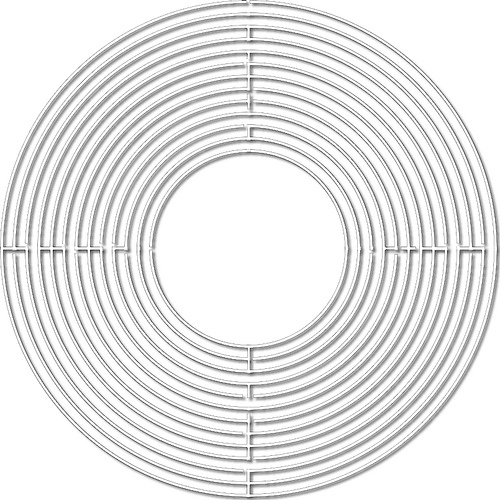

In [6]:
img = Image.open("images/ILSVRC2012_val_00000118.JPEG")
img

In [7]:
path_prefix = 'images/ILSVRC2012_val_00000'
path_suffix = '.JPEG'
discard_ratio = 0.9
image_size = 224

def convert_number(number):
    if number < 10:
        return '00'+str(number)
    if number < 100:
        return '0'+str(number)
    else:
        return str(number)

# img = Image.open(path_prefix + image_number_converted + path_suffix)

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [8]:
for image_number in range(1,121):
    print(f"Current image being treated: {image_number}")
    
    if image_number in [34, 107, 118]:
        with open(file_attention_flow_inverse, 'a') as f:
            f.write('\n') 
    else:
        
        image_number_converted = convert_number(image_number)
        image_path = path_prefix + image_number_converted + path_suffix
        input_tensor  = preprocess_image(image_path, transform)

        # Attention Flow Inverse
        model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        model.eval()
        attention_flow = VITAttentionFlowInverse(model, discard_ratio=discard_ratio)
        mask_attention_flow = attention_flow.get_attention_mask(input_tensor).numpy()
        mask_attention_flow = mask_attention_flow / np.max(mask_attention_flow)
        
        with open(file_attention_flow_inverse, 'a') as f:
            np.savetxt(f, [mask_attention_flow], fmt='%.3f', delimiter=',')  # Adjust format as needed

Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 1


100%|██████████| 197/197 [06:51<00:00,  2.09s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 2


100%|██████████| 197/197 [06:46<00:00,  2.06s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 3


100%|██████████| 197/197 [06:44<00:00,  2.05s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 4


100%|██████████| 197/197 [06:45<00:00,  2.06s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 5


100%|██████████| 197/197 [06:44<00:00,  2.05s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 6


100%|██████████| 197/197 [06:47<00:00,  2.07s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 7


100%|██████████| 197/197 [06:45<00:00,  2.06s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 8


100%|██████████| 197/197 [06:50<00:00,  2.08s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 9


100%|██████████| 197/197 [06:48<00:00,  2.07s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 10


 21%|██        | 41/197 [01:26<05:30,  2.12s/it]


KeyboardInterrupt: 

In [35]:
for image_number in range(119,121):
    print(f"Current image being treated: {image_number}")

    image_number_converted = convert_number(image_number)
    image_path = path_prefix + image_number_converted + path_suffix
    input_tensor  = preprocess_image(image_path, transform)

    # Getting idx
    model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
    model.eval()
    model.to(DEVICE)
    scores = model(input_tensor)
    category_index, _ = get_prediction(scores)

    # Attention Rollout
    model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
    model.eval()
    attention_rollout = VITAttentionRollout(model, discard_ratio=discard_ratio)
    mask_attention_rollout = attention_rollout.get_attention_mask(input_tensor).numpy()
    mask_attention_rollout = mask_attention_rollout / np.max(mask_attention_rollout)
    
    with open(file_attention_rollout, 'a') as f:
        np.savetxt(f, [mask_attention_rollout], fmt='%.3f', delimiter=',')  # Saving as float

    # Gradient Attention Rollout
    model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
    model.eval()
    attention_grad_rollout = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
    mask_attention_grad_rollout = attention_grad_rollout.get_attention_mask(input_tensor, category_index=category_index).numpy()
    mask_attention_grad_rollout = mask_attention_grad_rollout / np.max(mask_attention_grad_rollout)
    
    with open(file_attention_grad_rollout, 'a') as f:
        np.savetxt(f, [mask_attention_grad_rollout], fmt='%.3f', delimiter=',')  # Adjust format as needed

    # Attention Flow
    model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
    model.eval()
    attention_flow = VITAttentionFlow(model, discard_ratio=discard_ratio)
    mask_attention_flow = attention_flow.get_attention_mask(input_tensor).numpy()
    mask_attention_flow = mask_attention_flow / np.max(mask_attention_flow)
    
    with open(file_attention_flow, 'a') as f:
        np.savetxt(f, [mask_attention_flow], fmt='%.3f', delimiter=',')  # Adjust format as needed
    

Current image being treated: 119


Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 197/197 [07:37<00:00,  2.32s/it]
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


Current image being treated: 120


Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 197/197 [07:14<00:00,  2.21s/it]


In [ ]:
# import requests
# import torch.nn.functional as F

# LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
# classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

In [ ]:
# input_tensor  = preprocess_image("examples/input.png", transform)
# scores = model(input_tensor)

# def print_preds(scores):
#     # print the predictions with their 'probabilities' from the scores
#     h_x = F.softmax(scores, dim=1).data.squeeze()
#     probs, idx = h_x.sort(0, True)
#     probs = probs.numpy()
#     idx = idx.numpy()
#     # output the prediction
#     for i in range(0, 5):
#         print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
#     return idx

# def get_prediction(scores):
#     '''Gets the index of max prob and the prob
#     '''
#     h_x = F.softmax(scores, dim=1).data.squeeze()
#     probs, idx = h_x.sort(0, True)
#     # output the prediction
#     return idx[0].item(), probs[0].item()

# idx, prob = get_prediction(scores)